In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_confusion_matrix

# Data Preparation

In [2]:
df_train = pd.read_csv('train_data.csv') 
df_test = pd.read_csv('test_data.csv')

In [3]:

df_train = df_train.drop(columns=[
     'averageRating', 'originalTitle', 
])

df_test = df_test.drop(columns=[
     'averageRating', 'originalTitle', 
])

In [4]:
my_dict = {
    '(0, 1]': 0,
    '(1, 2]': 0,
    '(2, 3]': 0,
    '(3, 4]': 0,
    '(4, 5]': 1,
    '(5, 6]': 1,
    '(6, 7]': 2,
    '(7, 8]': 3,
    '(8, 9]': 4,
    '(9, 10]': 5,
}
df_train['rating'] = df_train['rating'].map(my_dict)
df_test['rating'] = df_test['rating'].map(my_dict)

In [5]:
X_train = df_train.drop(columns=["rating"])
y_train = df_train["rating"]
X_test = df_test.drop(columns=["rating"])
y_test = df_test["rating"]

In [6]:
X_train.shape

(103679, 21)

In [7]:
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [8]:
from sklearn.utils.class_weight import compute_sample_weight

# This replicates class_weight='balanced'
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)


# XGBoost
https://xgboost.readthedocs.io/en/stable/python/python_intro.html

In [9]:
# !pip install xgboost

In [10]:
from xgboost import XGBClassifier

In [11]:
%%time

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.3],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 0.5, 1, 5, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 5, 10],
    
}

clf = XGBClassifier(
    tree_method='exact',
    use_label_encoder=False,
    objective='multi:softprob',)

random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_iter=600,
    n_jobs=-1,
    refit=True,
    verbose=1,
)

random_search.fit(X_train, y_train, sample_weight=sample_weights)

clf = random_search.best_estimator_

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\xgboost\training.py:183: UserWarning: [01:41:54] WARNING: D:\bld\xgboost-split_1745056707810\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy 0.42691571959041297
F1-score [0.2824278  0.50433109 0.38185478 0.48906561 0.37193532 0.25586354]
              precision    recall  f1-score   support

           0       0.23      0.37      0.28      1547
           1       0.49      0.52      0.50      9052
           2       0.44      0.34      0.38     11574
           3       0.54      0.44      0.49     14409
           4       0.33      0.43      0.37      6571
           5       0.18      0.42      0.26      1282

    accuracy                           0.43     44435
   macro avg       0.37      0.42      0.38     44435
weighted avg       0.45      0.43      0.43     44435

CPU times: total: 5h 3min 26s
Wall time: 2d 13min 59s


In [12]:
print(random_search.best_params_)

{'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.1}


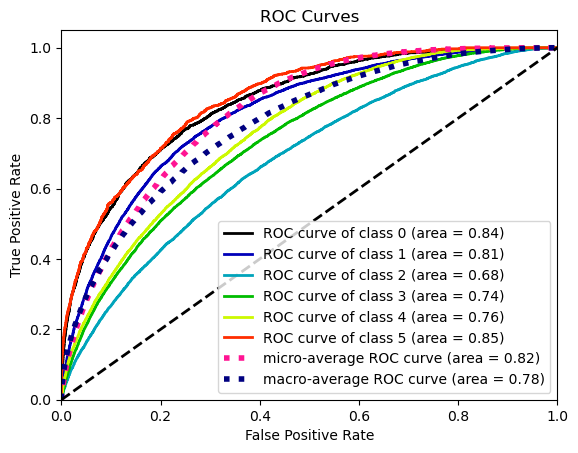

In [13]:
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [15]:
results = pd.DataFrame(random_search.cv_results_)

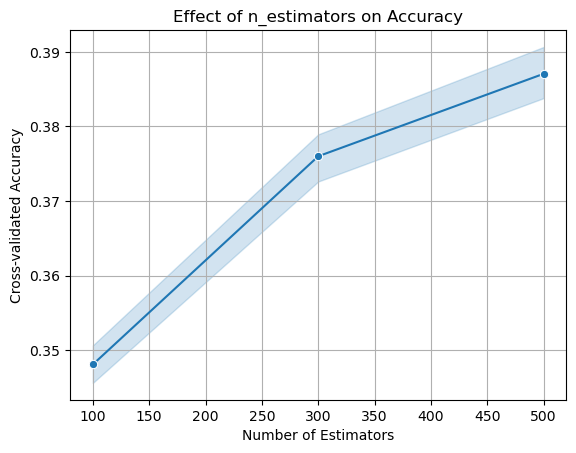

In [16]:
# Plot n_estimators vs. accuracy
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_score', marker='o')
plt.xlabel("Number of Estimators")
plt.ylabel("Cross-validated Accuracy")
plt.title("Effect of n_estimators on Accuracy")
plt.grid(True)
plt.show()

In [17]:
y_train_pred = clf.predict(X_train)

In [18]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))

Train Accuracy 0.7199336413352753
Train F1-score [0.73856951 0.77061868 0.70097116 0.73047074 0.69231414 0.60794756]

Test Accuracy 0.42691571959041297
Test F1-score [0.2824278  0.50433109 0.38185478 0.48906561 0.37193532 0.25586354]
